In [1]:
import pandas as pd
import numpy as np
import requests
import os
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
opts = webdriver.ChromeOptions()
opts.binary_location = os.environ.get('GOOGLE_CHROME_BIN', None)
opts.add_argument("--headless")
opts.add_argument("--disable-dev-shm-usage")
opts.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=opts)

In [2]:
url = "https://ark.intel.com/content/www/us/en/ark.html#@PanelLabel122139"
req = requests.get(url).text
page = bs(req, "html.parser")

hrefs = page.find("div", class_="products processors", attrs={"data-parent-panel-key":"PanelLabel122139", "style":"display: none;"}).find_all("a", href=True)
classes_links = []
for i in range(len(hrefs)):  
    classes_links.append(hrefs[i]["href"])

In [3]:
cpu_links=[]
for url in classes_links:
    class_url = "https://ark.intel.com" + url
    req1 = requests.get(class_url).text
    page1 = bs(req1, "html.parser")
    hrefs1 = page1.find("tbody").find_all("a")
    for i in range(len(hrefs1)):
        cpu_links.append(hrefs1[i]["href"])

len(cpu_links)

1071

In [4]:
features = ["MarketSegment", "Lithography", "CoreCount", "ThreadCount", "ClockSpeedMax", "TurboBoostMaxTechMaxFreq", "ClockSpeed", "Cache",
            "Bus", "MaxTDP", "BornOnDate"]
data = []

k = 0
for l in cpu_links:
    cpu_url = "https://ark.intel.com" + l
    driver.get(cpu_url)
    page2 = bs(driver.page_source, "html.parser")
    
    cpu_model = page2.find("h1", class_="h1").string.strip()
    data.append(cpu_model)
    
    check_price = page2.find("a", class_="view-modal info-modal", attrs={"data-modal":"tt-recommendedCustomerPrice"}) 
    if check_price is None:
        data.append(pd.NA)
    else:
        price = page2.find("span", class_="value", attrs={"data-key":""}).string
        data.append(price)


    for feature in features:
        try:
            f = page2.find("span", class_="value", attrs={"data-key":feature}).string.strip()
            data.append(f)
        except:
            data.append(pd.NA)
    k += 1
    if k%100==0:
        print(f"Product %d out of %d completed"%(k, len(cpu_links)))

Product 100 out of 1071 completed
Product 200 out of 1071 completed
Product 300 out of 1071 completed
Product 400 out of 1071 completed
Product 500 out of 1071 completed
Product 600 out of 1071 completed
Product 700 out of 1071 completed
Product 800 out of 1071 completed
Product 900 out of 1071 completed
Product 1000 out of 1071 completed


In [5]:
data = np.asarray(data).reshape(-1, 13)
df = pd.DataFrame(data)
df.columns = ["Model", "Price"] + features

df.to_csv("D:/Utente/Documenti/datasets/intel.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Model                     1071 non-null   object
 1   Price                     597 non-null    object
 2   MarketSegment             1071 non-null   object
 3   Lithography               1067 non-null   object
 4   CoreCount                 1071 non-null   object
 5   ThreadCount               948 non-null    object
 6   ClockSpeedMax             807 non-null    object
 7   TurboBoostMaxTechMaxFreq  110 non-null    object
 8   ClockSpeed                904 non-null    object
 9   Cache                     1071 non-null   object
 10  Bus                       884 non-null    object
 11  MaxTDP                    882 non-null    object
 12  BornOnDate                1071 non-null   object
dtypes: object(13)
memory usage: 108.9+ KB


We can drop TurboBoost since almost all values are null. All the rows where the price is missing have to be dropped as well since they're too many for an imputation.

In [2]:
df = pd.read_csv("D:/Utente/Documenti/datasets/intel.csv")
df.drop("TurboBoostMaxTechMaxFreq", axis=1, inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.dropna(inplace=True, subset="Price")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 1018
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          597 non-null    object 
 1   Price          597 non-null    object 
 2   MarketSegment  597 non-null    object 
 3   Lithography    596 non-null    object 
 4   CoreCount      597 non-null    int64  
 5   ThreadCount    569 non-null    float64
 6   ClockSpeedMax  513 non-null    object 
 7   ClockSpeed     433 non-null    object 
 8   Cache          597 non-null    object 
 9   Bus            425 non-null    object 
 10  MaxTDP         419 non-null    object 
 11  BornOnDate     597 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 60.6+ KB


Almost all variables are classified as object types. They have to be converted into numerical ones.
The following function convert prices into float objects. If they are reported as ranges, it returns the central value.

In [3]:
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)

def convert_price(price):
    try:
        values = price.split(' - ')
        min_value = float(values[0].replace('$', ''))
        max_value = float(values[1].replace('$', ''))
        return (min_value + max_value) / 2
    
    except:
        value = np.float64(price.replace("$", ""))
        return value
    

df["Price"] = df["Price"].apply(convert_price)

The variable MarketSegment has only three different values. To convert them into numbers we can resort to One Hot Encoding.

In [4]:
ohe = pd.get_dummies(df.MarketSegment)
df = df.join(ohe)
df.drop("MarketSegment", axis=1, inplace=True)

In [5]:
print(df["Lithography"].unique())

['14 nm' nan '22 nm' '32 nm' 'Intel 7' '10 nm SuperFin' '10 nm' '45 nm']


According to this website https://www.hpcwire.com/2021/07/27/intels-new-node-names-sapphire-rapids-now-an-intel-7-chip/, Intel 7 lithography corresponds to 10 nm. We'll use this information to make an imputation.

In [6]:
df.loc[df["Lithography"] == "Intel 7", "Lithography"] = 10
for i in range(df.shape[0]):
    try:
        df.loc[i, "Lithography"] = np.int8(df.loc[i, "Lithography"][:2])
    except:
        continue
    
df["Lithography"] = pd.to_numeric(df["Lithography"])

ClockSpeedMax, ClockSpeed must to be turned into numerical types as well.

In [7]:
print(df["ClockSpeedMax"].unique())

df["ClockSpeedMax"] = pd.to_numeric(df["ClockSpeedMax"].str.replace(" GHz", ""), errors='coerce')


print(df["ClockSpeed"].unique())

df["ClockSpeed"] = df["ClockSpeed"].str[:-4]
df["ClockSpeed"] = pd.to_numeric(df["ClockSpeed"], errors='coerce')

# Convert MHz to GHz
df.loc[df["ClockSpeed"] > 100, "ClockSpeed"] /= 1000

['4.50 GHz' '4.60 GHz' '4.40 GHz' '4.10 GHz' '4.20 GHz' '4.00 GHz'
 '3.60 GHz' '3.80 GHz' '3.70 GHz' '3.50 GHz' '3.90 GHz' '6.00 GHz'
 '5.60 GHz' '5.20 GHz' '5.40 GHz' '5.30 GHz' '5.00 GHz' '5.50 GHz'
 '5.80 GHz' '4.90 GHz' '5.10 GHz' '4.80 GHz' '4.70 GHz' nan '4.30 GHz'
 '3.40 GHz' '2.90 GHz' '3.20 GHz' '3.00 GHz' '3.30 GHz' '2.80 GHz'
 '2.70 GHz' '3.10 GHz' '2.20 GHz' '2.60 GHz' '3.73 GHz' '3.33 GHz'
 '2.93 GHz' '3.46 GHz' '3.86 GHz' '3.07 GHz' '3.06 GHz']
['3.70 GHz' '3.50 GHz' '3.30 GHz' '3.00 GHz' '3.80 GHz' '3.10 GHz'
 '2.60 GHz' '3.40 GHz' '3.60 GHz' '3.20 GHz' nan '1.80 GHz' '1.00 GHz'
 '1.70 GHz' '1.90 GHz' '1.10 GHz' '2.50 GHz' '1.30 GHz' '2.40 GHz'
 '1.40 GHz' '2.70 GHz' '1.20 GHz' '2.10 GHz' '2.30 GHz' '1.60 GHz'
 '1.50 GHz' '2.80 GHz' '3.90 GHz' '2.20 GHz' '2.90 GHz' '2.00 GHz'
 '4.10 GHz' '4.00 GHz' '4.20 GHz' '900 MHz' '800 MHz' '3.33 GHz'
 '3.46 GHz' '1.73 GHz' '1.86 GHz' '2.93 GHz' '3.06 GHz' '2.53 GHz'
 '2.13 GHz' '2.66 GHz' '2.83 GHz' '2.33 GHz' '2.26 GHz' '3.16 GHz'

As for the Cache, we can distinguish 4 types: basic, L2, L3 and Intel® Smart Cache. Since their performance gets better as the technlogy progresses, we can use a label encoder for them: the most recent the technology the higher the label.

In [8]:
for i in range(df.shape[0]):
    if "L2" in df.iloc[i, 7]:
        df.loc[i, "Cache"] = 1
    elif "L3" in df.iloc[i, 7]:
        df.loc[i, "Cache"] = 2
    elif "Intel® Smart Cache" in df.iloc[i, 7]:
        df.loc[i, "Cache"] = 3
    else:
        df.loc[i, "Cache"] = 0
        
df["Cache"] = pd.to_numeric(df["Cache"])

print(df["Cache"].unique())

[3 0 2 1]


The Bus variable is hard to standardize since Gigatransfers and Megahertz are not convertible into eachother. Might as well drop it.

In [9]:
df.drop("Bus", axis=1, inplace=True)

Convert MaxTDP into int type as well.

In [10]:
df["MaxTDP"] = pd.to_numeric(df["MaxTDP"].str.replace(" W", ""), errors='coerce')

The only variable not yet covered is the date of release. Since a time variable wouldn't fit into a price prediction model, we can just forget about it.

In [11]:
df.drop("BornOnDate", axis=1, inplace=True)

Now that we have converted all of our data into a workable format let's take a look at the bigger picture.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          597 non-null    object 
 1   Price          597 non-null    float64
 2   Lithography    596 non-null    float64
 3   CoreCount      597 non-null    int64  
 4   ThreadCount    569 non-null    float64
 5   ClockSpeedMax  513 non-null    float64
 6   ClockSpeed     433 non-null    float64
 7   Cache          597 non-null    int64  
 8   MaxTDP         419 non-null    float64
 9   Desktop        597 non-null    uint8  
 10  Embedded       597 non-null    uint8  
 11  Mobile         597 non-null    uint8  
dtypes: float64(6), int64(2), object(1), uint8(3)
memory usage: 43.9+ KB


We still have many null values, especially for MaxTDP and ClockSpeed. Let's check the descriptive statistics.

In [13]:
df.describe()

,Price,Lithography,CoreCount,ThreadCount,ClockSpeedMax,ClockSpeed,Cache,MaxTDP,Desktop,Embedded,Mobile
count,597.000000,596.000000,597.000000,569.000000,513.000000,433.000000,597.000000,419.000000,597.000000,597.000000,597.000000
mean,342.683417,16.969799,6.524288,10.783831,4.232651,2.708961,2.752094,59.985680,0.490787,0.152429,0.356784
std,206.700947,9.784867,4.623927,6.907387,0.663112,0.729965,0.767754,38.145479,0.500334,0.359737,0.479452
min,97.000000,10.000000,2.000000,4.000000,2.200000,0.800000,0.000000,4.500000,0.000000,0.000000,0.000000
25%,213.000000,10.000000,4.000000,4.000000,3.700000,2.300000,3.000000,35.000000,0.000000,0.000000,0.000000
50%,309.000000,14.000000,4.000000,8.000000,4.400000,2.800000,3.000000,55.000000,0.000000,0.000000,0.000000
75%,415.000000,22.000000,8.000000,16.000000,4.700000,3.300000,3.000000,77.000000,1.000000,0.000000,1.000000
max,1979.000000,45.000000,24.000000,36.000000,6.000000,4.200000,3.000000,165.000000,1.000000,1.000000,1.000000


Clockspeed's standard deviation isn't exaggerately high compared to its mean: that's good news since it allows us to substitute null values with the median without losing too many informations. On the other hand, MaxTDP presents both a very high SD and a very large interquartile range, it would be risky to make imputations with respect to null values. We can conclude that the best option is to just drop it.

As for the null values in the other variables, they're so few that it is safe to assume imputations won't do any harm. We choose to substitute them with the median since they belong to a small dataset, where the mean can easily be distorted by outliers.

In [14]:
df.drop("MaxTDP", axis=1, inplace=True)

imputations = df.columns[df.isnull().any()]

for i in imputations:
    df[i].fillna(df[i].median(), inplace=True)

It's done! The data has been processed: all of our variables are now in the correct data type and we don't have any null values. Let's check one more time to be sure.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          597 non-null    object 
 1   Price          597 non-null    float64
 2   Lithography    597 non-null    float64
 3   CoreCount      597 non-null    int64  
 4   ThreadCount    597 non-null    float64
 5   ClockSpeedMax  597 non-null    float64
 6   ClockSpeed     597 non-null    float64
 7   Cache          597 non-null    int64  
 8   Desktop        597 non-null    uint8  
 9   Embedded       597 non-null    uint8  
 10  Mobile         597 non-null    uint8  
dtypes: float64(5), int64(2), object(1), uint8(3)
memory usage: 39.2+ KB


Now for some data analysis. Let's start by plotting a correlation matrix.

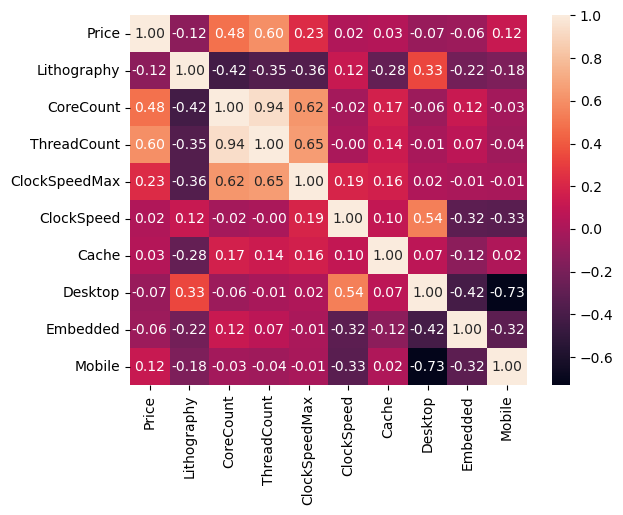

In [16]:
data = df.iloc[:, 1:]
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.show()

The correlation between the number of cores and the number of threads is next to 1. In order to avoid multicollinearity in our regression model we can exclude one of them.

In [17]:
data.drop("ThreadCount", axis=1, inplace=True)

Other interesting graphs...

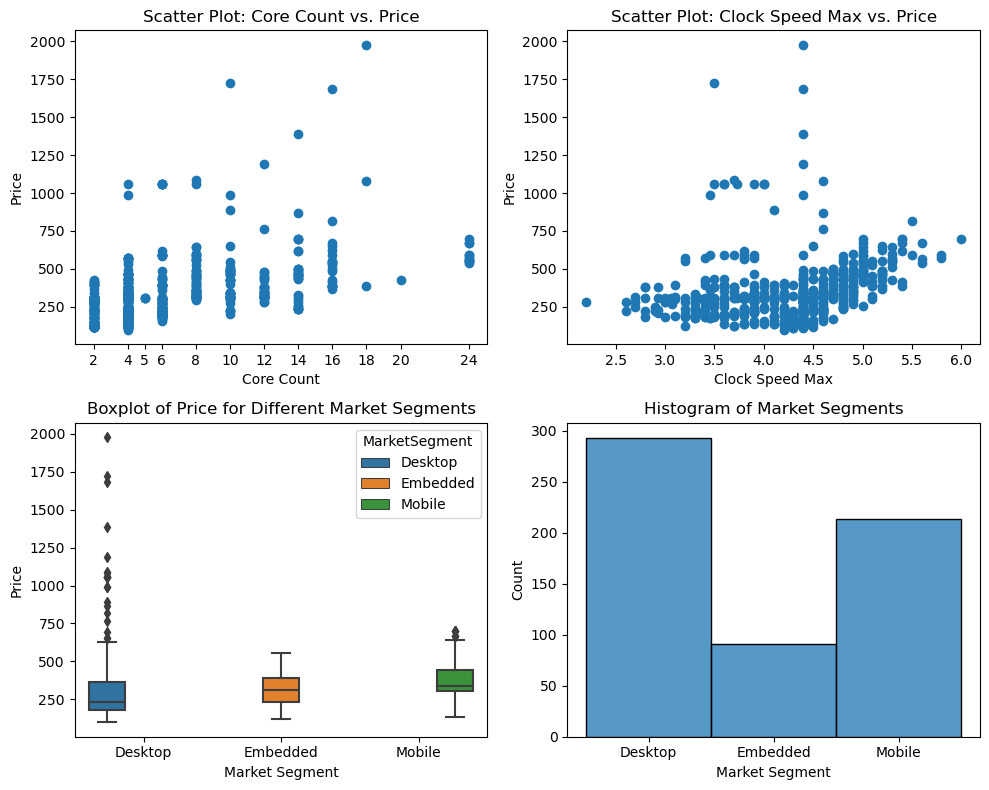

In [18]:
data['MarketSegment'] = data[['Desktop', 'Mobile', 'Embedded']].idxmax(axis=1)

# Create a 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Plot scatter plots on the first row
ax[0, 0].scatter(data["CoreCount"], data["Price"])
ax[0, 0].set_xticks(pd.unique(data["CoreCount"]))
ax[0, 0].set_xlabel('Core Count')
ax[0, 0].set_ylabel('Price')
ax[0, 0].set_title('Scatter Plot: Core Count vs. Price')

ax[0, 1].scatter(data["ClockSpeedMax"], data["Price"])
ax[0, 1].set_xlabel('Clock Speed Max')
ax[0, 1].set_ylabel('Price')
ax[0, 1].set_title('Scatter Plot: Clock Speed Max vs. Price')

# Plot the boxplot on the second row
sns.boxplot(x='MarketSegment', y='Price', data=data, ax=ax[1, 0], hue='MarketSegment')
ax[1, 0].set_xlabel('Market Segment')
ax[1, 0].set_ylabel('Price')
ax[1, 0].set_title('Boxplot of Price for Different Market Segments')

# Plot the histogram on the second row
sns.histplot(data=data, x='MarketSegment', stat='count', ax=ax[1, 1])
ax[1, 1].set_xlabel('Market Segment')
ax[1, 1].set_ylabel('Count')
ax[1, 1].set_title('Histogram of Market Segments')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

It appears to be a positive relationship between the price and both the number of cores and the maximum clock speed. We can try to predict the price of a CPU through a regression model using these variables.

From the CoreCount vs Price plot it would seem that the relationship between the two has a linear shape. On the other hand, the ClockSpeedMax vs Price plot suggests that the relationship in this case may be curvilinear.  

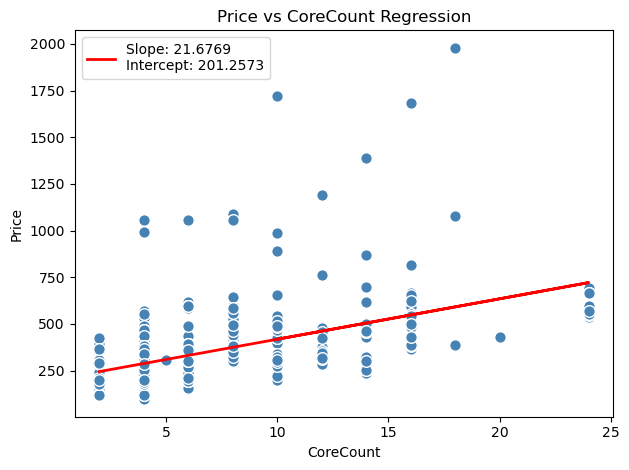

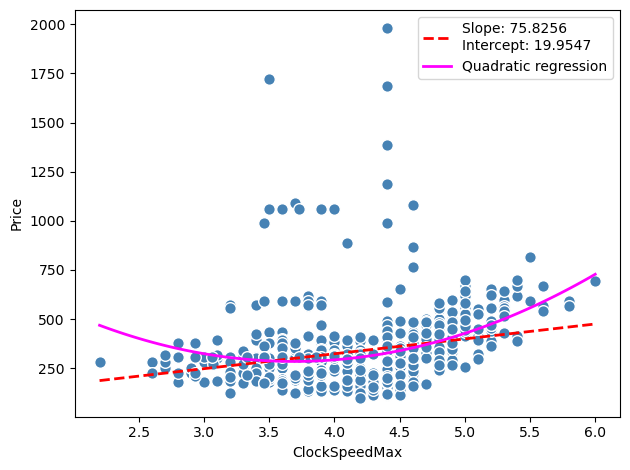

In [23]:
# This function will plot our results
def lin_regplot(x, y, model):
    plt.scatter(x, y, c="steelblue", edgecolor="white", s=70)
    plt.plot(x, model.predict(x), color="red", lw=2, linestyle='-', 
             label=f"Slope: {model.coef_[0][0]:.4f} \nIntercept: {model.intercept_[0]:.4f}")
    plt.legend()
    return None

x1 = np.asarray(data["CoreCount"]).reshape(-1, 1)
x2 =  np.asarray(data["ClockSpeedMax"]).reshape(-1, 1)
y =  np.asarray(data["Price"]).reshape(-1, 1)

# First model: predict price through the number of cores 
lr1 = LinearRegression()
lr1.fit(x1, y)
plt.title("Price vs CoreCount Regression")
lin_regplot(x1, y, lr1)
plt.xlabel("CoreCount")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# Second model: predict price through the maximum clock speed
# let's start with a simple linear regression...
x_fit = np.linspace(min(x2), max(x2), 100)
lr2 = LinearRegression()
lr2.fit(x2, y)
y_lin_fit = lr2.predict(x_fit)
# ... then estimate a 2nd order polinomial one
lr3 = LinearRegression()
quad = PolynomialFeatures(degree=2)
x2_quad = quad.fit_transform(x2)
lr3.fit(x2_quad, y)
y_quad_fit = lr3.predict(quad.fit_transform(x_fit))

plt.scatter(x2, y, c="steelblue", edgecolor="white", s=70)
plt.plot(x_fit, y_lin_fit, label=f"Slope: {lr2.coef_[0][0]:.4f} \nIntercept: {lr2.intercept_[0]:.4f}",
        linestyle="--", lw=2, color="red")
plt.plot(x_fit, y_quad_fit, label="Quadratic regression", color = "magenta", lw=2)
plt.xlabel("ClockSpeedMax")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

Both models seem to confirm what the exploratory analysis was already suggesting: the relationships between the price and the cores and the maximum clock speed are significantly positive. Also, it appears the intuiton we had about ClockSpeedMax was right: a quadratic fit seems to give better results than a simple linear regression. 

Since both explanatory variables seem good predictors for the price, it's a good idea to include both of them in a final regression model. We'll also need to know how accurately the final model will predict prices. To find that out we can perform a train test split.

X train: (447, 2)
X test: (150, 2)
Y train: (447,)
Y test: (150,)


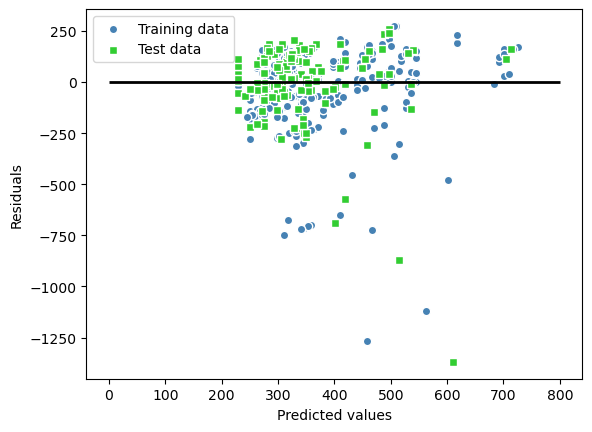

In [21]:
X = data[["ClockSpeedMax", "CoreCount"]].values
Y = data["Price"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0, shuffle=True)
print(f"X train: {X_train.shape}")
print(f"X test: {X_test.shape}")
print(f"Y train: {Y_train.shape}")
print(f"Y test: {Y_test.shape}")

# Now build the model
lr4 = LinearRegression()
lr4.fit(X_train, Y_train)
y_train_pred = lr4.predict(X_train)
y_test_pred = lr4.predict(X_test)

# To check the accuracy we can use a residual plot
train_resid = y_train_pred - Y_train
test_resid = y_test_pred - Y_test
plt.scatter(y_train_pred, train_resid, c="steelblue", marker="o", edgecolor="white", label="Training data")
plt.scatter(y_test_pred, test_resid, c="limegreen", marker="s", edgecolor="white", label="Test data")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend()
plt.hlines(y=0, xmin=0, xmax=800, color="black", lw=2)
plt.show()

If the prediction was perfect, all residuals should have collapsed on the black line, which is of course nearly impossible in real applications.
In our case, the plot shows that residuals are for the vast part concentrated along the black line, even though their distribution seem to be slightly skewed to the right, meaning that some relevant informations are still hidden inside the error term. 

Other metrics of accuracy are the Mean Squared Error and the R squared, which we can easily compute with ScikitLearn.

In [22]:
lr_MSE_train = mean_squared_error(Y_train, y_train_pred)
lr_MSE_test = mean_squared_error(Y_test, y_test_pred)

lr_r2_train = r2_score(Y_train, y_train_pred)
lr_r2_test = r2_score(Y_test, y_test_pred)

print("TRAIN DATA: MSE = %.4f R^2 = %.4f"%(lr_MSE_train, lr_r2_train))
print("TEST DATA: MSE = %.4f R^2 = %.4f"%(lr_MSE_test, lr_r2_test))

TRAIN DATA: MSE = 30660.1662 R^2 = 0.2365
TEST DATA: MSE = 37059.0029 R^2 = 0.2597


The MSE in the test dataset is far superior to the one in the training dataset, which means the model overfits during the training phase.
The R^2 presents very low values for both training and test data: the model can hardly explain around 25% of the total variance of the data.